# Описание проекта

__Выбор локации для скважины__

### Контекст и задача бизнеса

Добывающая компания планирует инвестиции в бурение новых скважин и должна выбрать регион, где разработка обеспечит **максимальную ожидаемую прибыль** при **контролируемом уровне финансового риска**.

Доступны данные по трём регионам: в каждом — по **100 000 потенциальных месторождений** с измеренными геолого-технологическими признаками, а также целевой переменной — **объёмом запасов**.

### Цель проекта

Выбрать регион для разработки, который:

* максимизирует **ожидаемую прибыль**,
* соответствует ограничениям бюджета,
* имеет **допустимую вероятность убытков** (оценка риска).

**Цель исследования**

Определить регион для разработки нефтяных скважин, который обеспечит максимальную ожидаемую прибыль при допустимом уровне финансовых рисков.

Построить и оценить модели машинного обучения для прогнозирования объёма запасов нефти в скважинах, используя линейную регрессию, и сравнить регионы по качеству прогнозов и экономическим показателям.

На основе анализа прибыли и рисков методом Bootstrap выбрать регион, наиболее подходящий для инвестиций с учётом ограничений по бюджету и допустимой вероятности убытков.

---

**Ход исследования**

**1. Загрузка и подготовка данных**

- Загрузка данных -
Загружены три датасета геологоразведки, содержащие информацию о 100 000 месторождениях в каждом регионе.

- Предобработка данных -
Проверено качество данных

- Исследовательский анализ данных -
Проанализированы распределения признаков и целевой переменной. Выявлены различия в структуре данных между регионами, включая мультимодальность распределений и ступенчатую структуру целевой переменной в одном из регионов.

- Корреляционный анализ - 
Проведён анализ зависимостей с использованием коэффициентов Spearman и Phik.


**2. Обучение и оценка модели**

- Разделение данных -
Данные каждого региона разделены на обучающую и валидационную выборки в соотношении 75:25.

- Использование пайплайнов -
Созданы пайплайны с предобработкой числовых признаков (масштабирование) и моделью линейной регрессии.

- Обучение модели -
Модели обучены отдельно для каждого региона.

- Оценка качества модели -
Качество прогнозов оценено по метрике RMSE. 


**3. Подготовка к расчету прибыли**
 - Зафиксированы ключевые параметры: бюджет, количество разрабатываемых скважин, стоимость одной скважины и доход на тысячу баррелей нефти.
 - Определён минимальный объём запасов одной скважины для безубыточной разработки. 


**4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели**
Реализована функция, выбирающая 200 скважин с максимальными предсказанными значениями и рассчитывающая прибыль на основе фактических запасов.


**5. Оценка прибыли и рисков методом Bootstrap**
С помощью Bootstrap (1000 выборок) получены распределения прибыли для каждого региона, рассчитаны средняя прибыль, 95%-й доверительный интервал и риск убытков.

## Загрузка и подготовка данных

In [1]:
# Для установки модуля 'phik' 
!pip install -q phik

In [2]:
# Импорт библиотек 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error


state = np.random.RandomState(1234)


In [3]:
# Глобальные константы

BUDGET = 10000000000
PRICE_PER_UNIT = 450000
TOP_WELLS = 200
POINTS_TO_CHECK = 500
N_BOOTSTRAP = 1000
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Загружаем датасеты
df_0 = pd.read_csv('/datasets/geo_data_0.csv') 
df_1 = pd.read_csv('/datasets/geo_data_1.csv') 
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Предобработка данных <a id="предобработка_данных"></a>

__Создадим функцию для вывода нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)__

In [5]:
def look_data(x):
    print('------------- Исходный датафрейм (5 cтрок) -------------')
    display(x.head())
    print('')
    print('')
    print('------------- Общая информация о датафрейме -------------')
    print('')
    print('')
    display(x.info())
    print('------------- Количество пустых значений в датафрейме -------------')
    print('')
    print('')
    display(x.isna().sum())
    print('------------- Количество явных дубликатов в датафрейме -------------')
    display(x.duplicated().sum())
    print('')
    print('')
    print('------------- Описательная статистика -------------')
    display(x.drop(columns=['id']).describe())
    print('------------- Проверим уникальные значения нечисловых колонок -------------')
    print('')
    print('')
    object_cols = x.select_dtypes(include='object').columns
    for col in object_cols:
        unique_vals = x[col].unique()
        print(f"Столбец: {col}")
        print(f"Количество уникальных значений: {len(unique_vals)}")
        print(f"Уникальные значения: {unique_vals}")
        print('-' * 60)
    print('------------- Проверим уникальные значения числовых колонок -------------')
    print('')
    print('')    
    numeric_cols = x.select_dtypes(include='number').columns
    for col in numeric_cols:
        unique_vals = x[col].unique()
        print(f"Столбец: {col}")
        print(f"Количество уникальных значений: {len(unique_vals)}")
        print(f"Уникальные значения: {unique_vals}")
        print('-' * 60)

In [6]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
look_data(df_0)

------------- Исходный датафрейм (5 cтрок) -------------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

------------- Количество пустых значений в датафрейме -------------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0



------------- Описательная статистика -------------


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: id
Количество уникальных значений: 99990
Уникальные значения: ['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
------------------------------------------------------------
------------- Проверим уникальные значения числовых колонок -------------


Столбец: f0
Количество уникальных значений: 100000
Уникальные значения: [0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]
------------------------------------------------------------
Столбец: f1
Количество уникальных значений: 100000
Уникальные значения: [-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]
------------------------------------------------------------
Столбец: f2
Количество уникальных значений: 100000
Уникальные значения: [ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]
------------------------------------------------------------
Столбец: product
Количество уни

In [7]:
df_0[df_0['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


In [8]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
look_data(df_1)

------------- Исходный датафрейм (5 cтрок) -------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

------------- Количество пустых значений в датафрейме -------------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0



------------- Описательная статистика -------------


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: id
Количество уникальных значений: 99996
Уникальные значения: ['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
------------------------------------------------------------
------------- Проверим уникальные значения числовых колонок -------------


Столбец: f0
Количество уникальных значений: 100000
Уникальные значения: [-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]
------------------------------------------------------------
Столбец: f1
Количество уникальных значений: 100000
Уникальные значения: [-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]
------------------------------------------------------------
Столбец: f2
Количество уникальных значений: 100000
Уникальные значения: [-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]
-------------------------------------------------------

In [9]:
df_1[df_1['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [10]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
look_data(df_2)

------------- Исходный датафрейм (5 cтрок) -------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

------------- Количество пустых значений в датафрейме -------------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0



------------- Описательная статистика -------------


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: id
Количество уникальных значений: 99996
Уникальные значения: ['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']
------------------------------------------------------------
------------- Проверим уникальные значения числовых колонок -------------


Столбец: f0
Количество уникальных значений: 100000
Уникальные значения: [-1.1469871   0.2627779   0.19458728 ... -1.19993432 -2.41989641
 -2.55142066]
------------------------------------------------------------
Столбец: f1
Количество уникальных значений: 100000
Уникальные значения: [ 0.96332792  0.26983896  0.289035   ... -2.95763723  2.41722066
 -2.02562514]
------------------------------------------------------------
Столбец: f2
Количество уникальных значений: 100000
Уникальные значения: [-0.82896492 -2.53018652 -5.58643277 ...  5.219411   -5.54844392
  6.09089066]
------------------------------------------------------------
Столбец: product
Количес

In [11]:
df_2[df_2['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


### Предобработка данных - краткий вывод по данным

В распоряжении три датасета, каждый содержит информацию о 100 000 месторождениях из разных регионов. Во всех датасетах присутствуют одни и те же признаки: `f0`, `f1`, `f2` и целевая переменная `product`, а также идентификатор `id`.

**Качество данных**

* Пропуски отсутствуют во всех регионах.
* Явных полных дубликатов нет.
* Есть небольшое количество повторяющихся значений в столбце `id`, но строки при этом различаются — это не влияет на моделирование, так как столбец `id` не используется как признак.
* Типы данных корректные: признаки и целевая переменная — `float`, `id` — `object`.

**Статистические особенности регионов**

* **Регион 0**

  * `product` распределён непрерывно, среднее ≈ **92.5**.
  * Данные выглядят наиболее «естественно», без явных артефактов.

* **Регион 1**

  * У целевой переменной всего **12 уникальных значений**, что говорит о ступенчатой структуре данных.
  * Среднее значительно ниже — **68.8**, присутствует сильный разброс признаков.
  * Это может усложнить точные предсказания модели.

* **Регион 2**

  * Похож на первый регион: непрерывное распределение `product`, среднее ≈ **95**, что является наиболее высоким среди трёх регионов.
  * Признаки распределены более стабильно.

### Исследовательский анализ данных <a id="исследовательский_анализ_данных"></a>

__Создадим вспомогательную функции для EDA__

__Разделение признаков на continuous / discrete / category:__

In [12]:
# категориальные признаки 
# в датасете отсутствуют (id не используются в модели)
category = [
]

# дискретные числовые признаки
# в датасете отсутствуют (все числовые признаки являются непрерывными)
discrete = [
]

# непрерывные числовые признаки
continuous = [
    'f0',
    'f1',
    'f2',
    'product'
]

__Словарь подписей (для нашей функции): ключ = имя столбца, значение = [title, xlabel, ylabel]:__

In [13]:
label_dict = {  
    # непрерывные числовые признаки
    'f0': [
        "Распределение признака f0",
        "Значение f0",
        "Количество месторождений"
    ],
    'f1': [
        "Распределение признака f1",
        "Значение f1",
        "Количество месторождений"
    ],
    'f2': [
        "Распределение признака f2",
        "Значение f2",
        "Количество месторождений"
    ],
    'product': [
        "Распределение запасов нефти (product)",
        "Объём запасов",
        "Количество месторождений"
    ]
}

__Функция для EDA__

In [14]:
def learn_data(df):
    def get_labels(col):
        vals = label_dict.get(col, None)
        if vals is None:
            return [f"Распределение: {col}", col, "Количество наблюдений"]
        vals = list(vals) + [""] * (3 - len(vals))
        return vals[:3]

    for col in df.columns:
        if col == 'id':
            continue

        print(f"\n==== {col} ==== \n")
        title, xlabel, ylabel = get_labels(col)

        # Непрерывные
        if col in continuous:
            print(df[col].describe(), "\n")

            # Гистограмма
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=50)
            plt.title(title if title else f"Гистограмма: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.tight_layout()
            plt.show()

            # Boxplot
            plt.figure(figsize=(4, 6))
            plt.boxplot(df[col].dropna(), vert=True, showmeans=True)
            plt.title(f"Boxplot: {col}")
            plt.ylabel(xlabel if xlabel else col)
            plt.tight_layout()
            plt.show()

        # Дискретные
        elif col in discrete:
            print(df[col].describe(), "\n")
            
            # bar chart
            plt.figure(figsize=(6, 4))
            df[col].value_counts(dropna=False).sort_index().plot(
                kind="bar", grid=True
            )
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        # Категориальные
        elif col in category:
            print(df[col].describe(), "\n")
            
            # bar chart
            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
            
            # pie chart           
            plt.figure(figsize=(5, 5))
            plt.pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                counterclock=False,
                wedgeprops={'edgecolor': 'white'}
            )
            pie_title = f"Доля категорий — {xlabel}" if xlabel else f"Доля категорий: {col}"
            plt.title(pie_title)
            plt.tight_layout()
            plt.show()

        else:
            # Фоллбэк для непомеченных колонок
            print(df[col].describe(), "\n")
            counts = df[col].value_counts(dropna=False)
            
            # bar chart
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()


==== f0 ==== 

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64 



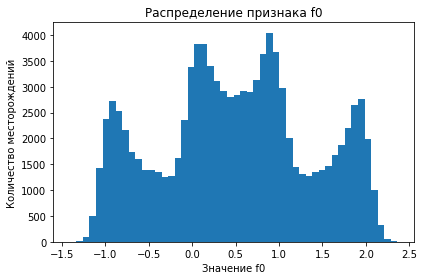

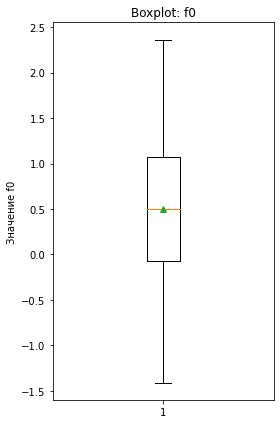


==== f1 ==== 

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64 



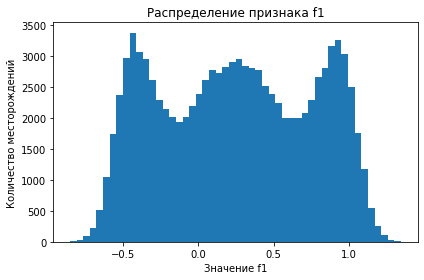

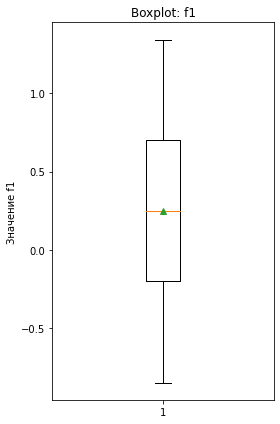


==== f2 ==== 

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64 



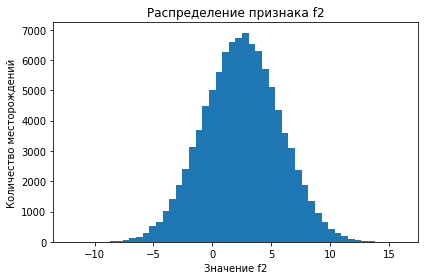

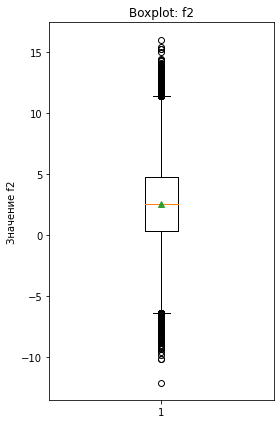


==== product ==== 

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64 



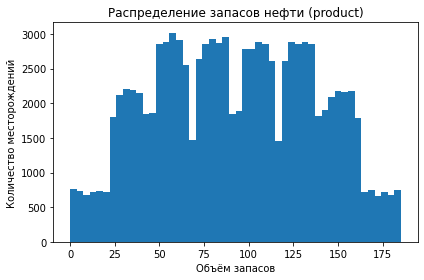

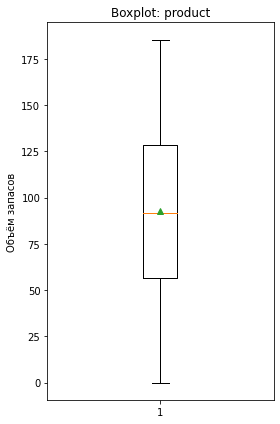

In [15]:
learn_data(df_0)


==== f0 ==== 

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64 



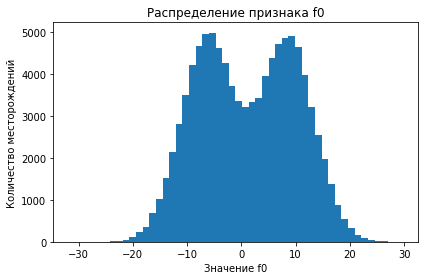

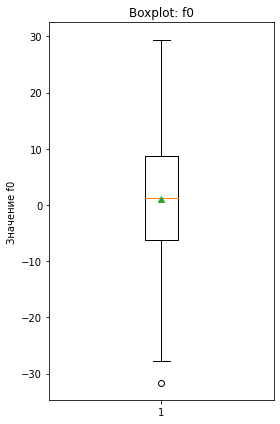


==== f1 ==== 

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64 



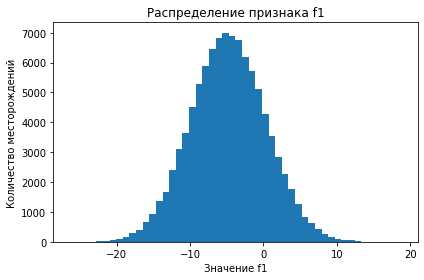

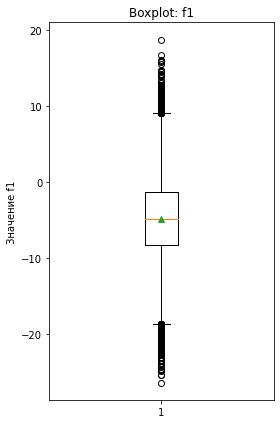


==== f2 ==== 

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64 



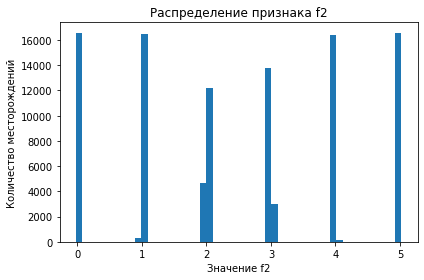

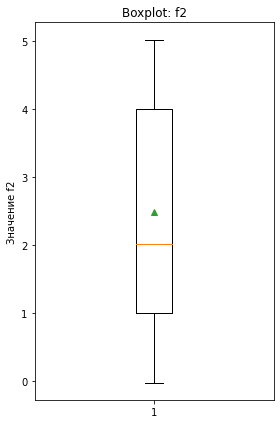


==== product ==== 

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64 



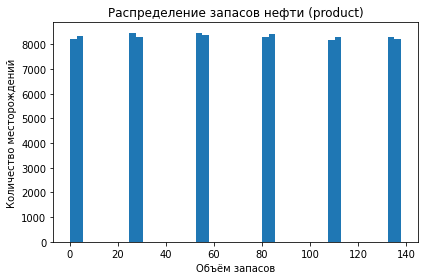

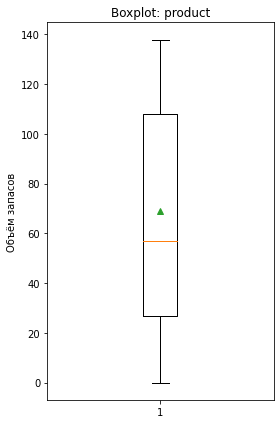

In [16]:
learn_data(df_1)


==== f0 ==== 

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64 



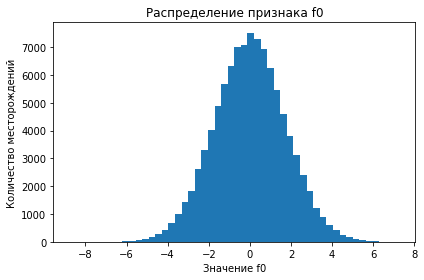

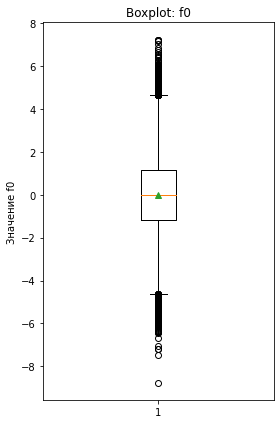


==== f1 ==== 

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64 



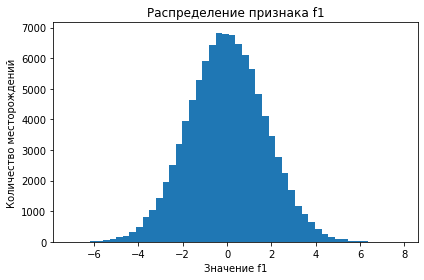

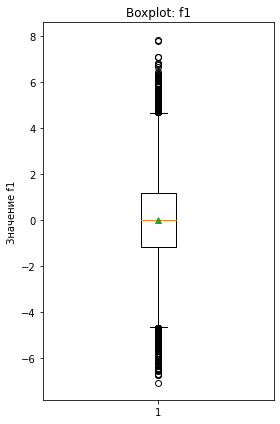


==== f2 ==== 

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64 



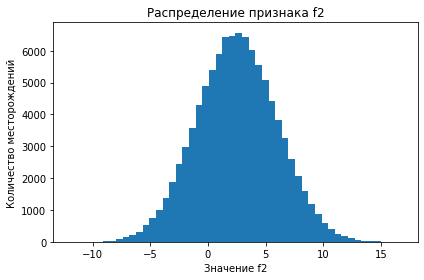

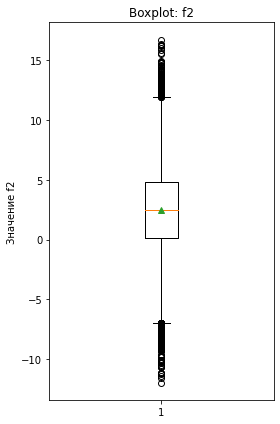


==== product ==== 

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64 



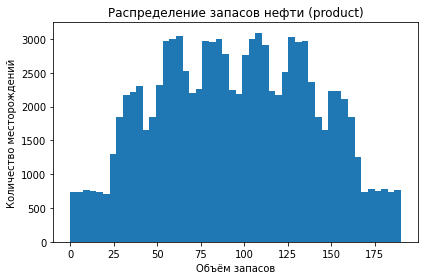

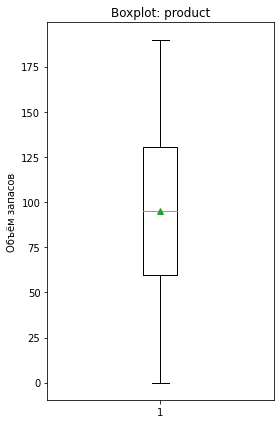

In [17]:
learn_data(df_2)

### Вывод по 3 таблицам - Исследовательский анализ данных

Анализ трёх регионов показал существенные различия в структуре признаков и распределении запасов нефти, что напрямую влияет на выбор модели и ожидаемую прибыль.

---

**Регион 0**

Данные региона 0 демонстрируют **сложную мультимодальную структуру**:

* Признак **f0** имеет четырёхмодальное распределение, указывая на вероятность наличия нескольких типов месторождений и геологических условий.
* Признак **f1** — трёхмодальный, что также, возможно, говорит о неоднородности региона.
* Признак **f2** по форме близок к нормальному распределению без резких аномалий.
* Распределение целевой переменной **product** характеризуется широким диапазоном значений – от 0 до 185.36 тыс. баррелей. Среднее значение составляет 92.5, а медиана — 91.85, что свидетельствует об отсутствии существенного смещения распределения. Межквартильный размах находится в пределах 56.50–128.56 тыс. баррелей, что указывает на значительную вариативность запасов месторождений. Гистограмма показывает, что малые значения product (близкие к нулю) встречаются сравнительно редко, тогда как основная масса наблюдений распределена в широком диапазоне средних и крупных значений. Внутри этого диапазона частоты расположены относительно равномерно: нет ярко выраженного единого пика, и значения встречаются достаточно равномерно по всему интервалу.

**Вывод по региону:** регион, вероятно, структурно разнообразен, содержит несколько кластеров. Подходит для моделирования, однако из-за мультимодальности может потребовать более гибких моделей или тщательной проверки качества.

---

**Регион 1**

Регион 1 отличается **неоднородностью признаков** и специфической структурой:

* Признак **f0** — отчётливо двумодальный, что, вероятно, свидетельствует о двух крупных подгруппах месторождений.
* Признак **f1** распределён колоколообразно, но центр смещён в область отрицательных значений.
* Признак **f2** имеет ступенчатую структуру и ограниченный диапазон значений.
* Целевая переменная **product** принимает ограниченное число уровней, что приводит к ступенчатой гистограмме и снижает плавность данных.

**Вывод по региону:** регион 1 выглядит неоднородным и «шумным». Ограниченность уровней целевой переменной и нестабильность признаков могут снизить точность регрессии. Этот регион потенциально менее надёжен для прогнозирования и получения высокой прибыли.

---

**Регион 2**

Регион 2 демонстрирует наиболее благоприятную структуру для построения модели:

* **f0** имеет форму, близкую к нормальному распределению, с хорошей симметрией и без признаков мультимодальности.
* **f1** распределён почти нормально и симметрично, что говорит о стабильности и хорошей пригодности для линейных моделей.
* **f2** имеет почти нормальную форму распределения, с более широкими хвостами.
* Целевая переменная **product** распределена равномерно в широком диапазоне, без выраженной моды и без перекоса. Данные содержат как небольшие месторождения, так и крупные, что повышает разнообразие выборки.

**Вывод по региону:** регион 2 обладает самой стабильной и предсказуемой структурой данных, что делает его наиболее подходящим для моделирования.

### Корреляционный анализ <a id="корреляционный_анализ "></a>

#### Correlation matrix - для df_0

__Spearman - для df_0__

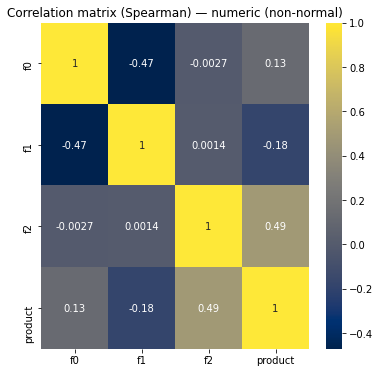

In [18]:
num_cols_0 = df_0.select_dtypes(include='number').columns.tolist()
num_cols_0 = [c for c in num_cols_0 if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(df_0[num_cols_0].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [19]:
df_0[num_cols_0].corr(method='spearman')

,f0,f1,f2,product
f0,1.000000,-0.471395,-0.002685,0.128417
f1,-0.471395,1.000000,0.001413,-0.181143
f2,-0.002685,0.001413,1.000000,0.486394
product,0.128417,-0.181143,0.486394,1.000000


__Phik: числовые + категориальные - для df_0__

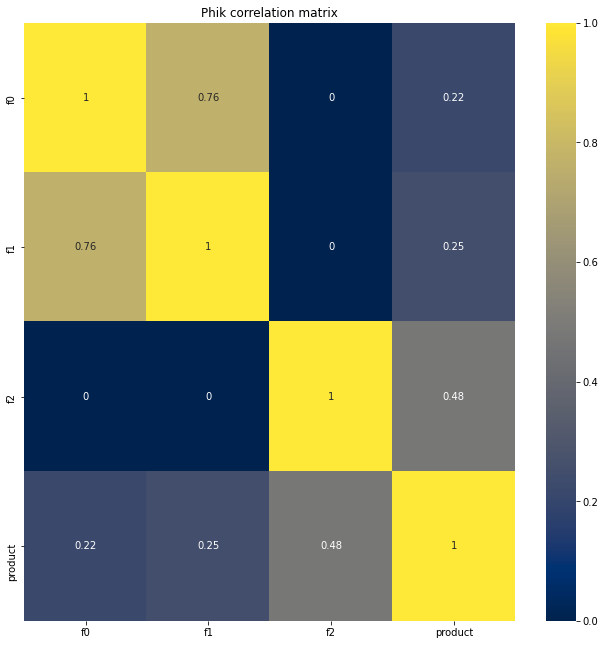

In [20]:
phik_corr_0 = df_0.drop(columns=['id']).phik_matrix(
    interval_cols=['f0',
    'f1',
    'f2',
    'product']
)

plt.figure(figsize=(11, 11))
sns.heatmap(phik_corr_0, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [21]:
phik_corr_0

,f0,f1,f2,product
f0,1.000000,0.762170,0.000000,0.215525
f1,0.762170,1.000000,0.000000,0.253544
f2,0.000000,0.000000,1.000000,0.475901
product,0.215525,0.253544,0.475901,1.000000


#### Correlation matrix - для df_1

__Spearman - для df_1__

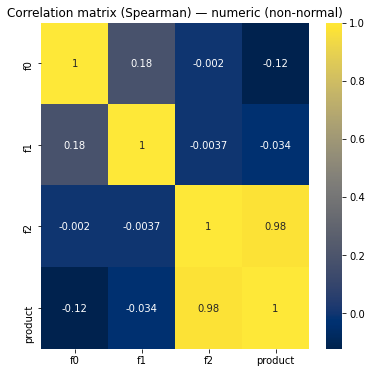

In [22]:
num_cols_1 = df_1.select_dtypes(include='number').columns.tolist()
num_cols_1 = [c for c in num_cols_1 if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(df_1[num_cols_1].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [23]:
df_1[num_cols_1].corr(method='spearman')

,f0,f1,f2,product
f0,1.000000,0.182248,-0.002000,-0.122869
f1,0.182248,1.000000,-0.003678,-0.033908
f2,-0.002000,-0.003678,1.000000,0.975605
product,-0.122869,-0.033908,0.975605,1.000000


__Phik: числовые + категориальные - для df_1__

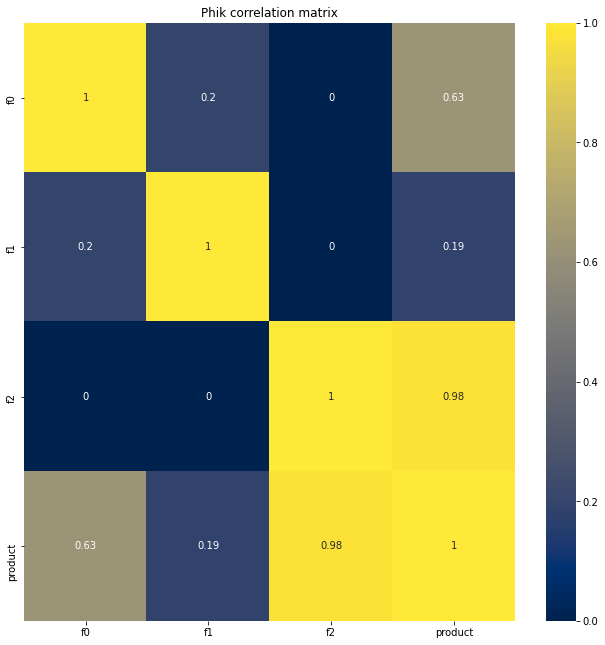

In [24]:
phik_corr_1 = df_1.drop(columns=['id']).phik_matrix(
    interval_cols=['f0',
    'f1',
    'f2',
    'product']
)

plt.figure(figsize=(11, 11))
sns.heatmap(phik_corr_1, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [25]:
phik_corr_1

,f0,f1,f2,product
f0,1.000000,0.196080,0.000000,0.628482
f1,0.196080,1.000000,0.000000,0.185965
f2,0.000000,0.000000,1.000000,0.978936
product,0.628482,0.185965,0.978936,1.000000


#### Correlation matrix - для df_2

__Spearman - для df_2__

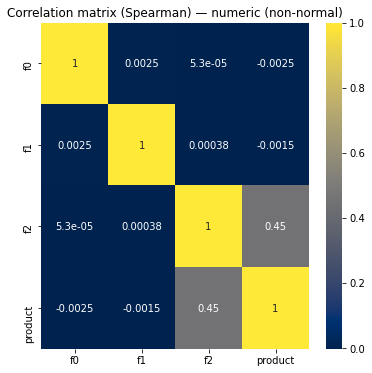

In [26]:
num_cols_2 = df_2.select_dtypes(include='number').columns.tolist()
num_cols_2 = [c for c in num_cols_2 if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(df_2[num_cols_2].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [27]:
df_2[num_cols_2].corr(method='spearman')

,f0,f1,f2,product
f0,1.000000,0.002493,0.000053,-0.002464
f1,0.002493,1.000000,0.000378,-0.001463
f2,0.000053,0.000378,1.000000,0.448463
product,-0.002464,-0.001463,0.448463,1.000000


__Phik: числовые + категориальные - для df_2__

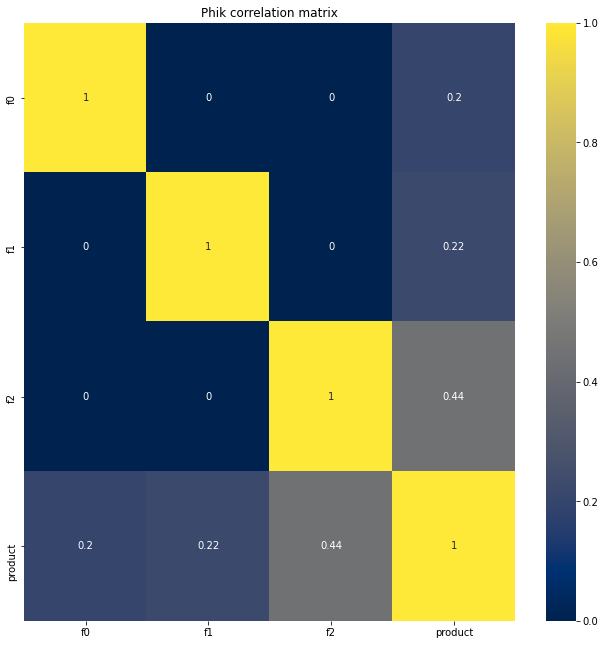

In [28]:
phik_corr_2 = df_2.drop(columns=['id']).phik_matrix(
    interval_cols=['f0',
    'f1',
    'f2',
    'product']
)

plt.figure(figsize=(11, 11))
sns.heatmap(phik_corr_2, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [29]:
phik_corr_2

,f0,f1,f2,product
f0,1.000000,0.000000,0.000000,0.201068
f1,0.000000,1.000000,0.000000,0.221022
f2,0.000000,0.000000,1.000000,0.443287
product,0.201068,0.221022,0.443287,1.000000


#### Выводы по корреляционному анализу (df_0, df_1, df_2)

Корреляционный анализ выполнен двумя способами:
**Spearman** — выявляет монотонные связи между числовыми признаками.
**Phik** — универсальная мера зависимости для любых типов признаков.

Ниже — структурированные выводы по каждому региону и общий итог.


##### Регион 0

**Spearman**

* f0 ↔ product = **0.128** (слабая связь)
* f1 ↔ product = **–0.181** (слабая обратная связь)
* f2 ↔ product = **0.486** (средняя положительная связь — самая сильная в регионе)

**Phik**

* product ↔ f0 = **0.2155**
* product ↔ f1 = **0.2535**
* product ↔ f2 = **0.4759**

**Вывод по региону 0**

* Ярко выраженная зависимость целевой переменной есть только у признака **f2**.
* Признаки f0 и f1 слабо влияют на результат.
* Модель может давать нормальную точность, но из-за мультимодальных распределений поведение признаков сложное.

#####  Регион 1

**Spearman**

* f0 ↔ product = **–0.123** (слабая обратная)
* f1 ↔ product = **–0.034** (почти нулевая)
* f2 ↔ product = **0.9756** (очень сильная, практически детерминированная)

**Phik**

* product ↔ f0 = **0.628**
* product ↔ f1 = **0.186**
* product ↔ f2 = **0.9789**

**Вывод по региону 1**

* Признак **f2 полностью определяет product** (из-за ступенчатых одинаковых значений product).
* Модель легко обучается, но:

  * данные искусственные/ступенчатые,
  * низкая вариативность значений product,
  * высокая корреляция может быть следствием артефактной генерации данных.

Регион **нестабилен**, может давать переобучение и риск плохих прогнозов на реальных данных.


#####  Регион 2

**Spearman**

* f0 ↔ product = –0.002 (нулевая)
* f1 ↔ product = –0.001 (нулевая)
* f2 ↔ product = **0.448** (умеренная связь)

**Phik**

* product ↔ f0 = **0.201**
* product ↔ f1 = **0.221**
* product ↔ f2 = **0.443**

**Вывод по региону 2**

* Связи умеренные, без экстремумов и аномалий.
* Признак **f2** снова самый важный.
* Данные региона ровные, распределения близки к нормальным.

Регион 2 даёт **самые стабильные и предсказуемые данные** — оптимальная структура для построения ML-модели.



#####  Общий итог по корреляционному анализу

- Во всех регионах **главным предиктором является признак f2**

- Признаки f0 и f1 имеют слабые или нулевые связи с целевой переменной product

- Регион 1 имеет аномальную корреляцию (0.97), что указывает на ступенчатость и низкое разнообразие данных. Показывает слишком высокую зависимость одного признака и выглядит ненадёжным.

- Регион 2 — **самый сбалансированный и качественный**

- Регион 0 — средний по сложности

## Обучение и проверка модели

### Регион 0

In [30]:
# готовим данные
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    df_0.drop(['id','product'], axis=1),
    df_0['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
    )

print("Размерности выборок:")
print("X_train_0:", X_train_0.shape)
print("X_valid_0:", X_valid_0.shape)
print("y_train_0:", y_train_0.shape)
print("y_valid_0:", y_valid_0.shape)

num_columns_0 = X_train_0.select_dtypes(include='number').columns.tolist()

# создаём пайплайн для подготовки признаков
scaler_num_0 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
]) 


# препроцессор
data_preprocessor_0 = ColumnTransformer(
    [('num', scaler_num_0, num_columns_0)], 
    remainder='drop'
)


# создаём итоговый пайплайн: подготовка данных и модель
model_0 = Pipeline([
    ('preprocessor', data_preprocessor_0),
    ('regression', LinearRegression())
])

model_0.fit(X_train_0, y_train_0)
predictions_0 = model_0.predict(X_valid_0)

rmse_0 = mean_squared_error(y_valid_0, predictions_0, squared=False)
print("Средний запас предсказанного сырья:", predictions_0.mean())
print("RMSE_0:", rmse_0)

Размерности выборок:
X_train_0: (75000, 3)
X_valid_0: (25000, 3)
y_train_0: (75000,)
y_valid_0: (25000,)
Средний запас предсказанного сырья: 92.39879990657768
RMSE_0: 37.75660035026169


### Краткие выводы:

* Модель линейной регрессии для региона 0 показала **средний предсказанный объём запасов**, близкий к фактическому среднему значению по региону, что говорит об отсутствии смещения в прогнозах.
* Значение **RMSE ≈ 37.8 тыс. баррелей** означает, что средняя ошибка прогноза составляет около 38 тыс. баррелей на одну скважину.
* С учётом масштаба целевой переменной и слабых корреляций между признаками качество модели можно считать **удовлетворительным**.
* Полученные результаты позволяют использовать модель для **дальнейшего расчёта прибыли и оценки рисков**, что соответствует требованиям задачи.


### Регион 1

In [31]:
# готовим данные
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    df_1.drop(['id','product'], axis=1),
    df_1['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
    )

print("Размерности выборок:")
print("X_train_1:", X_train_1.shape)
print("X_valid_1:", X_valid_1.shape)
print("y_train_1:", y_train_1.shape)
print("y_valid_1:", y_valid_1.shape)

num_columns_1 = X_train_1.select_dtypes(include='number').columns.tolist()

# создаём пайплайн для подготовки признаков
scaler_num_1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
]) 


# препроцессор
data_preprocessor_1 = ColumnTransformer(
    [('num', scaler_num_1, num_columns_1)], 
    remainder='drop'
)


# создаём итоговый пайплайн: подготовка данных и модель
model_1 = Pipeline([
    ('preprocessor', data_preprocessor_1),
    ('regression', LinearRegression())
])

model_1.fit(X_train_1, y_train_1)
predictions_1 = model_1.predict(X_valid_1)

rmse_1 = mean_squared_error(y_valid_1, predictions_1, squared=False)
print("Средний запас предсказанного сырья:", predictions_1.mean())
print("RMSE_1:", rmse_1)

Размерности выборок:
X_train_1: (75000, 3)
X_valid_1: (25000, 3)
y_train_1: (75000,)
y_valid_1: (25000,)
Средний запас предсказанного сырья: 68.7128780391376
RMSE_1: 0.8902801001028846


### Краткие выводы (Регион 1)

- Модель линейной регрессии для региона 1 показала средний предсказанный объём запасов, практически совпадающий с фактическим средним значением по региону, что указывает на отсутствие систематического смещения в прогнозах.

- Значение RMSE ≈ 0.89 тыс. баррелей свидетельствует о крайне малой средней ошибке прогноза на одну скважину, что объясняется особенностями структуры данных региона.

- Сильная зависимость целевой переменной от признака f2 обеспечивает высокое качество модели, однако ограниченное число возможных значений product указывает на искусственный характер данных.

- Несмотря на высокие показатели точности, полученные результаты следует интерпретировать с осторожностью, однако они позволяют использовать модель для дальнейших расчётов прибыли и оценки рисков в рамках поставленной задачи.

### Регион 2

In [32]:
# готовим данные
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    df_2.drop(['id','product'], axis=1),
    df_2['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
    )

print("Размерности выборок:")
print("X_train_2:", X_train_2.shape)
print("X_valid_2:", X_valid_2.shape)
print("y_train_2:", y_train_2.shape)
print("y_valid_2:", y_valid_2.shape)

num_columns_2 = X_train_2.select_dtypes(include='number').columns.tolist()

# создаём пайплайн для подготовки признаков
scaler_num_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
]) 

# препроцессор
data_preprocessor_2 = ColumnTransformer(
    [('num', scaler_num_2, num_columns_2)], 
    remainder='drop'
)


# создаём итоговый пайплайн: подготовка данных и модель
model_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('regression', LinearRegression())
])

model_2.fit(X_train_2, y_train_2)
predictions_2 = model_2.predict(X_valid_2)

rmse_2 = mean_squared_error(y_valid_2, predictions_2, squared=False)
print("Средний запас предсказанного сырья:", predictions_2.mean())
print("RMSE_2:", rmse_2)

Размерности выборок:
X_train_2: (75000, 3)
X_valid_2: (25000, 3)
y_train_2: (75000,)
y_valid_2: (25000,)
Средний запас предсказанного сырья: 94.77102387765939
RMSE_2: 40.145872311342174


### Краткие выводы (Регион 2)

- Модель линейной регрессии для региона 2 показала средний предсказанный объём запасов, близкий к фактическому среднему значению по региону, что указывает на отсутствие существенного смещения в прогнозах.

- Значение RMSE ≈ 40.1 тыс. баррелей означает, что средняя ошибка прогноза составляет около 40 тыс. баррелей на одну скважину, что сопоставимо с масштабом целевой переменной.

- Относительно высокая величина ошибки свидетельствует о более сложной структуре данных.

- Полученные результаты позволяют использовать модель для дальнейших расчётов прибыли и оценки рисков, однако при выборе региона следует учитывать повышённый уровень неопределённости прогнозов.

In [33]:
def train_evaluate_region(df):
    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['id', 'product'], axis=1),
        df['product'],
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    num_columns = X_train.select_dtypes(include='number').columns.tolist()
    
    scaler_num = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        [('num', scaler_num, num_columns)],
        remainder='drop'
    )
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regression', LinearRegression())
    ])
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    
    print("Размерности выборок:")
    print("X_train:", X_train.shape)
    print("X_valid:", X_valid.shape)
    print("Средний запас предсказанного сырья:", predictions.mean())
    print("RMSE:", rmse)
    
    return predictions, y_valid, rmse

__Регион 0__

In [34]:
predictions_0, y_valid_0, rmse_0 = train_evaluate_region(df_0)

Размерности выборок:
X_train: (75000, 3)
X_valid: (25000, 3)
Средний запас предсказанного сырья: 92.39879990657768
RMSE: 37.75660035026169


__Регион 1__

In [35]:
predictions_1, y_valid_1, rmse_1 = train_evaluate_region(df_1)

Размерности выборок:
X_train: (75000, 3)
X_valid: (25000, 3)
Средний запас предсказанного сырья: 68.7128780391376
RMSE: 0.8902801001028846


__Регион 2__

In [36]:
predictions_2, y_valid_2, rmse_2 = train_evaluate_region(df_2)

Размерности выборок:
X_train: (75000, 3)
X_valid: (25000, 3)
Средний запас предсказанного сырья: 94.77102387765939
RMSE: 40.145872311342174


## Подготовка к расчёту прибыли

### Ключевые параметры для расчётов

#### Расчёт прибыли и рисков 

__Для расчёта прибыли и оценки рисков были зафиксированы следующие параметры__

- бюджет на разработку региона — 10 млрд рублей;

- количество скважин, отобранных для разработки — 200;

- количество исследуемых скважин — 500;

- доход с одной тысячи баррелей нефти — 450 тыс. рублей.

#### Минимальный объём сырья для безубыточной разработки

Минимальный объём запасов для безубыточной разработки одной скважины рассчитывается как отношение бюджета к количеству разрабатываемых скважин и доходу с одной тысячи баррелей:

In [37]:
min_vol = 10000000000/(200*450000)
min_vol

111.11111111111111

Минимальный объём запасов для безубыточной разработки одной скважины ≈ 111.1 тыс. баррелей

__Сравнение с средними запасами по регионам показывает:__

- Регион 0: средний запас ≈ 92.4 тыс. баррелей — ниже порога безубыточности;

- Регион 1: средний запас ≈ 68.7 тыс. баррелей — существенно ниже порога;

- Регион 2: средний запас ≈ 95 тыс. баррелей — также ниже порога безубыточности.

Таким образом, ни в одном регионе средний объём запасов одной скважины не превышает порог безубыточности, что подчёркивает необходимость использования модели машинного обучения для отбора наиболее перспективных скважин, а не случайного выбора.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

__Логика функции__ - 

- Из скважин выбираем 200 с максимальными предсказаниями модели.

- Берём реальные значения product для этих скважин.

- Считаем суммарный объём сырья и переводим его в прибыль с учётом бюджета.

In [38]:
def calculate_profit(predictions, target):
    # приводим предсказания к Series с теми же индексами, что и таргет
    series_predictions = pd.Series(predictions, index=target.index)
    
    # отбираем индексы 200 лучших по прогнозу
    top_indices = series_predictions.sort_values(ascending=False).index
    
    # отбираем 200 в таргете
    top_target = target.loc[top_indices].head(TOP_WELLS)
    
    # считаем суммарный реальный объём
    total_product = top_target.sum()
    
    # считаем прибыль
    revenue = total_product * PRICE_PER_UNIT
    profit = revenue - BUDGET
    
    return profit

In [39]:
profit_0 = calculate_profit(predictions_0, y_valid_0)
profit_1 = calculate_profit(predictions_1, y_valid_1)
profit_2 = calculate_profit(predictions_2, y_valid_2)

print(f"Прибыль региона 0: {profit_0:,.0f} руб.")
print(f"Прибыль региона 1: {profit_1:,.0f} руб.")
print(f"Прибыль региона 2: {profit_2:,.0f} руб.")

Прибыль региона 0: 3,359,141,114 руб.
Прибыль региона 1: 2,415,086,697 руб.
Прибыль региона 2: 2,598,571,759 руб.


##	Оценка прибыли и рисков методом Bootstrap

__Создаем функцию для прибылей по Bootstrap (1000 выборок)__

In [40]:
def bootstrap_profit(predictions, actual):
    profits = []
    
    for i in range(1000):
        sample_actual = actual.sample(n=500, replace=True, random_state=state)
        sample_predictions = pd.Series(predictions, index=actual.index)[sample_actual.index]
        profit = calculate_profit(sample_predictions, sample_actual)
        profits.append(profit)
    
    return pd.Series(profits)

### Регион 0

In [41]:
bootstrap_profit_0 = bootstrap_profit(predictions_0,  y_valid_0)

mean_profit_0 = bootstrap_profit_0.mean()
lower_ci_0 = bootstrap_profit_0.quantile(0.025)
upper_ci_0 = bootstrap_profit_0.quantile(0.975)
risk_0 = (bootstrap_profit_0 < 0).mean()

print(f"Средняя прибыль: {mean_profit_0:,.0f} руб.")
print(f"95% доверительный интервал: [{lower_ci_0:,.0f}, {upper_ci_0:,.0f}] руб.")
print(f"Риск убытков: {risk_0:.2%}")

Средняя прибыль: 438,951,096 руб.
95% доверительный интервал: [-101,898,293, 997,500,484] руб.
Риск убытков: 5.60%


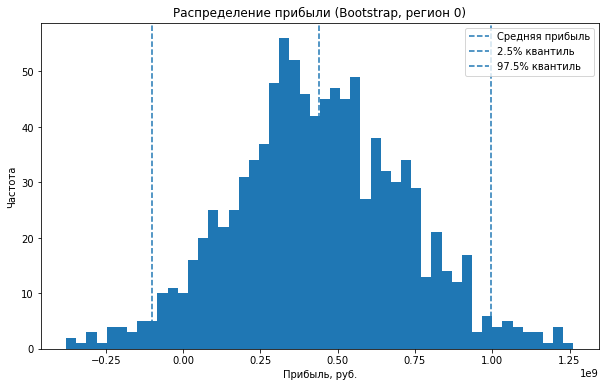

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_profit_0, bins=50)
plt.axvline(mean_profit_0, linestyle='--', label='Средняя прибыль')
plt.axvline(lower_ci_0, linestyle='--', label='2.5% квантиль')
plt.axvline(upper_ci_0, linestyle='--', label='97.5% квантиль')

plt.title('Распределение прибыли (Bootstrap, регион 0)')
plt.xlabel('Прибыль, руб.')
plt.ylabel('Частота')
plt.legend()
plt.show()

__Краткий вывод:__

Bootstrap-распределение прибыли для региона 0 показывает положительную среднюю прибыль — 438 951 096 руб. Однако 95% доверительный интервал равен [-101 898 293; 997 500 484] руб., то есть нижняя граница отрицательная. Это означает, что вероятность получить убыток не исключается. Оценка риска убытков составляет 5.60%, что выше порога 2.5% по условию задачи, поэтому регион 0 не проходит критерий по риску и не является предпочтительным кандидатом для разработки.

### Регион 1

In [43]:
bootstrap_profit_1 = bootstrap_profit(predictions_1,  y_valid_1)

mean_profit_1 = bootstrap_profit_1.mean()
lower_ci_1 = bootstrap_profit_1.quantile(0.025)
upper_ci_1 = bootstrap_profit_1.quantile(0.975)
risk_1 = (bootstrap_profit_1 < 0).mean()

print(f"Средняя прибыль: {mean_profit_1:,.0f} руб.")
print(f"95% доверительный интервал: [{lower_ci_1:,.0f}, {upper_ci_1:,.0f}] руб.")
print(f"Риск убытков: {risk_1:.2%}")

Средняя прибыль: 497,920,832 руб.
95% доверительный интервал: [98,052,722, 933,043,497] руб.
Риск убытков: 0.90%


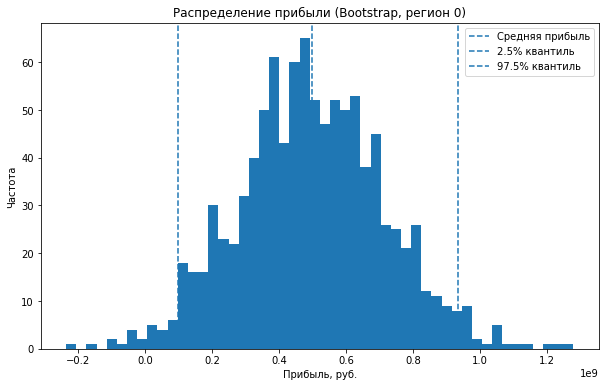

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_profit_1, bins=50)
plt.axvline(mean_profit_1, linestyle='--', label='Средняя прибыль')
plt.axvline(lower_ci_1, linestyle='--', label='2.5% квантиль')
plt.axvline(upper_ci_1, linestyle='--', label='97.5% квантиль')

plt.title('Распределение прибыли (Bootstrap, регион 0)')
plt.xlabel('Прибыль, руб.')
plt.ylabel('Частота')
plt.legend()
plt.show()

__Краткий вывод:__

Распределение прибыли, полученное с помощью Bootstrap, показывает положительную среднюю прибыль (497,920,832 руб.) для региона 0. Риск убытков составляет около 0.90%, что является приемлимым значением к разработке в соответствии с условиями задачи.

### Регион 2

In [45]:
bootstrap_profit_2 = bootstrap_profit(predictions_2,  y_valid_2)

mean_profit_2 = bootstrap_profit_2.mean()
lower_ci_2 = bootstrap_profit_2.quantile(0.025)
upper_ci_2 = bootstrap_profit_2.quantile(0.975)
risk_2 = (bootstrap_profit_2 < 0).mean()

print(f"Средняя прибыль: {mean_profit_2:,.0f} руб.")
print(f"95% доверительный интервал: [{lower_ci_2:,.0f}, {upper_ci_2:,.0f}] руб.")
print(f"Риск убытков: {risk_2:.2%}")

Средняя прибыль: 410,681,832 руб.
95% доверительный интервал: [-166,072,510, 1,008,023,777] руб.
Риск убытков: 6.70%


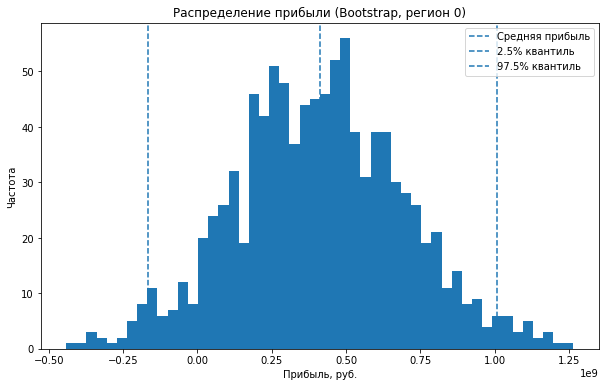

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_profit_2, bins=50)
plt.axvline(mean_profit_2, linestyle='--', label='Средняя прибыль')
plt.axvline(lower_ci_2, linestyle='--', label='2.5% квантиль')
plt.axvline(upper_ci_2, linestyle='--', label='97.5% квантиль')

plt.title('Распределение прибыли (Bootstrap, регион 0)')
plt.xlabel('Прибыль, руб.')
plt.ylabel('Частота')
plt.legend()
plt.show()

__Краткий вывод:__

Bootstrap-распределение прибыли для региона 2 показывает положительную среднюю прибыль — 410 681 832 руб. Однако 95% доверительный интервал равен [-166 072 510; 1 008 023 777] руб., то есть включает отрицательные значения. Риск убытков составляет 6.70%, что существенно превышает допустимый порог 2.5% по условию задачи. Следовательно, регион 2 не удовлетворяет критериям по риску и не рекомендуется к разработке.

## Итоговые выводы и выбор региона для разработки

- Для каждого региона построена модель линейной регрессии (по условию задачи), выполнена проверка качества на валидационной выборке (75/25), после чего рассчитана прибыль при отборе 200 лучших скважин из 500 и оценены риски методом **Bootstrap (1000 выборок)**. 
- Порог безубыточности для одной скважины составил **≈ 111.1 тыс. баррелей**, при этом средние запасы во всех регионах ниже этого порога, поэтому важен именно **отбор наиболее перспективных скважин по прогнозам модели**, а не выбор “средней” скважины.

__Наблюдения по данным (EDA и корреляции)__

Корреляционный анализ (Spearman/Phik) показал, что во всех регионах наиболее информативным признаком выступает **f2**, тогда как f0 и f1 в основном имеют слабую/нулевую связь с целевой переменной. При этом:

* **Регион 0:** умеренная связь f2 с product (Spearman ≈ 0.49), признаки имеют мультимодальные распределения → структура данных сложнее, выше неопределённость.
* **Регион 1:** практически детерминированная связь f2 с product (Spearman ≈ 0.98) и ступенчатая структура `product` (мало уникальных значений) → модель прогнозирует очень точно, но данные выглядят “искусственно”. В рамках задачи это допустимо, но интерпретацию стоит делать осторожно.
* **Регион 2:** умеренная связь f2 с product (Spearman ≈ 0.45), распределения признаков более стабильные, однако финансовый риск по Bootstrap оказывается выше допустимого.

Таким образом, EDA и корреляции объясняют различия в качестве прогнозов и устойчивости прибыли по регионам.

__Результаты Bootstrap (прибыль и риск)__

**Регион 0**

* Средняя прибыль: ≈ 438.9 млн руб.
* 95% доверительный интервал: [–101.9 млн; 997.5 млн] руб.
* Риск убытков: 5.60% ❌

Регион 0 не удовлетворяет ограничению по риску: доверительный интервал включает отрицательные значения, а вероятность убытков превышает допустимый порог 2.5%.

**Регион 1**

* Средняя прибыль: ≈ 497.9 млн руб.
* 95% доверительный интервал: [98.1 млн; 933.0 млн] руб.
* Риск убытков: 0.90% ✅

Регион 1 демонстрирует устойчивый положительный финансовый результат: доверительный интервал полностью находится в положительной области, а риск убытков существенно ниже порогового значения. Высокая корреляция f2 → product объясняет низкую ошибку модели и стабильность прибыли в Bootstrap.

**Регион 2**

* Средняя прибыль: ≈ 410.7 млн руб.
* 95% доверительный интервал: [–166.1 млн; 1 008.0 млн] руб.
* Риск убытков: 6.70% ❌

Регион 2 не проходит ограничение по риску: доверительный интервал пересекает ноль, а вероятность убытков существенно превышает допустимый уровень 2.5%.

---

__Рекомендация__

Согласно условию задачи, к разработке допускаются регионы с риском убытков **< 2.5%**, а среди них выбирается регион с **максимальной средней прибылью**.

**Рекомендуемый регион для разработки — регион 1**, потому что:

* является единственным регионом, удовлетворяющим ограничению по риску;
* он имеет **максимальную среднюю прибыль**;
* демонстрирует **минимальный риск убытков (0.90%)**;
* его устойчивость подтверждается Bootstrap, однако мы видим высокую зависимость `product` от `f2` (корреляции Spearman/Phik) 
